<h1>
<center>Final Project: Default of Credit Card Clients</center>
</h1>

<h1>
<center>Haotian Zhang, Zepei Zhu</center>
</h1>

<h1>
<center>CFRM 521, Spring 2021</center>
</h1>

<h2>Data Glimpse</h2>

In [2]:
#Load data
import pandas as pd
import numpy as np

filename = 'default of credit card clients.xls'
data = pd.read_excel(filename,skiprows=1)

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

<h2>Project Blueprint</h2>

This dataset records the information of 30,000 (observations) Taiwan credit card clients. The project is to try to establish a predictive method that allows the creditor to make conscious decisions in rendering credits to credit card applicants, and to minimize the risk of default. The dataset is from Department of Information Management, Chung Hua University, Taiwan, and Department of Civil Engineering, Tamkang University, Taiwan. 

<h2>DATA SNAPSHOT</h2>

There are 30,000 observations and 24 features in this dataset. Some labels are very self-explanatory, like GENDER and MARITAL STATUS etc, whereas others may not necessarily be the case. We will provide detailed information of the obscured features.

PAY_0 - PAY_6 renders monthly payment record. So PAY_0 is the record of September 2005, PAY_1 is for August 2005,...,PAY_6 is for April 2005. This is a multi-label catagorical label:The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 

BILL_AMT1 - BILL_AMT6 indicates the amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

PAY_AMT1 - PAY_AMT6 signifies the amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

In [5]:
data['default payment next month'].value_counts()/len(data['default payment next month'])

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

<h2>Word of Caution</h2>

1. No missing values in datasets, therefore no imputation needed.

2. This is a skewed dataset (as indicated above), most clients (77.88%) do not default on their credit card payments. Stratified sampling is employed to ensure the proportion of default/undefalut clients are the same in training and test set. F1 score and AUC, in addition to accuracy, are also considered in this project to account for the skewedness.

3. ID does not carry meaningful information. SEX, EDUCATION, MARRIAGE,PAY_0 to PAY_6 are categorical attributes, and the rest  are numerical attributes.



<h2>Preprocessing</h2>

In [2]:
#create training set, validation set and test set (stratified sampling)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.2,random_state = 42)
for train_valid_index, test_index in split.split(data, data['default payment next month']):
    train_valid_set = data.iloc[train_valid_index]
    test_set = data.iloc[test_index]

for train_index, valid_index in split.split(train_valid_set,train_valid_set['default payment next month']):
    train_set = train_valid_set.iloc[train_index]
    valid_set = train_valid_set.iloc[valid_index]

X_train = train_set.drop('default payment next month',axis=1)
y_train = train_set['default payment next month'].copy()

X_valid = valid_set.drop('default payment next month',axis=1)
y_valid = valid_set['default payment next month'].copy()

X_test = test_set.drop('default payment next month',axis=1)
y_test = test_set['default payment next month'].copy()

In [3]:
# Preprocessing data
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

attribute = list(X_train)
attribute.remove('ID')
attribute.remove('AGE')
cat_attribute = attribute[1:10]
num_attribute = list(X_train)
num_attribute.remove('ID')
for item in cat_attribute:
    num_attribute.remove(item)

num_pipeline = Pipeline([('Select_numeric',DataFrameSelector(num_attribute)),
                        ('Standard_Scale',StandardScaler())])

cat_pipeline = Pipeline([('Select_cat',DataFrameSelector(cat_attribute)),
                        ('cat_enconder',OneHotEncoder(sparse=False))])

final_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),
                                               ('cat_pipeline',cat_pipeline)])

X_train_scale = final_pipeline.fit_transform(X_train)
X_valid_scale = final_pipeline.transform(X_valid)
X_test_scale = final_pipeline.transform(X_test)

<h2>Metric Used</h2>

**1. Accuracy**

**2. F1 Score**

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)

**3. AUC**

Area Under the Receiver Operating Characteristic Curve (ROC AUC)

<h2>Method Overview</h2>

**Accuracy**

Logistic: 0.8189$\newline$
Linear SVM: 0.8187$\newline$
SGD: 0.8137$\newline$
SVM with RBF: 0.82$\newline$
Random Forest: 0.8156$\newline$
Hard voting classifier: 0.8160$\newline$
Soft voting classifier: 0.8177$\newline$
Adaboost: 0.8185$\newline$
Gradient Boosting: 0.8164$\newline$
ANN: 0.8160

**F1 Score**

Logistic Regression: 0.4739$\newline$
Linear SVM: 0.4720$\newline$
SGD: 0.4186$\newline$
SVM with RBF: 0.4605$\newline$
Random Forest: 0.4303$\newline$
Hard voting classifier: 0.4045$\newline$
Soft voting classifier: 0.4351$\newline$
Adaboost: 0.4580$\newline$
Gradient Boosting: 0.4505

**AUC**

Logistic: 0.7717$\newline$
SGD: 0.7645$\newline$
SVM with RBF: 0.72$\newline$
Random Forest: 0.7599$\newline$
ANN: 0.7740$\newline$

<h2>Logistic Regression</h2>

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

logic_reg = LogisticRegression(C=np.inf,random_state=42,solver='lbfgs',max_iter=2000)
logic_reg.fit(X_train_scale,y_train)
logic_reg_pred = logic_reg.predict(X_valid_scale)
accuracy_score(y_valid,logic_reg_pred)

0.8179166666666666

With the default setting, the validation accuracy is around 82%. Let's tune for the best hyperparameters and try again.

In [8]:
#search for hyperparameter C
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform

param_distribus = {'C':uniform(0.001,3)}
logic_reg = LogisticRegression(random_state=42,solver='lbfgs',max_iter=20000)
logistic_rnSearch = RandomizedSearchCV(logic_reg, param_distributions= param_distribus,
                                      n_iter=25,cv=3,scoring='f1',random_state=42,verbose=1,n_jobs=-1)

logistic_rnSearch.fit(X_train_scale,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=20000,
                                                random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdab4537f70>},
                   random_state=42, scoring='f1', verbose=1)

In [9]:
logistic_rnSearch.best_params_

{'C': 0.8746874205941257}

In [10]:
logistic_rnSearch.best_score_

0.4738627091699567

In [11]:
y1 = logistic_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.8189583333333333

Slight improvement is seen! Let's check for overfitting.

In [12]:
# function to check for overfitting
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def plot_learning_curves(model, X_train, y_train, X_valid, y_valid):
    train_errors, val_errors = [],[]
    for m in range(100, len(X_train),100):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_valid)
        train_errors.append(f1_score(y_train[:m], y_train_predict))
        val_errors.append(f1_score(y_valid, y_val_predict))
            
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size(hundreds)", fontsize=14) 
    plt.ylabel("F1 Score", fontsize=14)


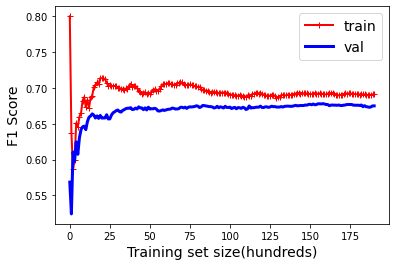

In [13]:
# check if Logistic Regression is overfitting 
plot_learning_curves(logistic_rnSearch.best_estimator_,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

Logistic regression is slightly overfitting.

<h2>Linear SVM Classifier</h2>

In [14]:
from sklearn.svm import LinearSVC

linear_svm_clf = LinearSVC(random_state=42,max_iter=20000)
linear_svm_clf.fit(X_train_scale,y_train)
linear_svm_clf_pred = linear_svm_clf.predict(X_valid_scale)
accuracy_score(y_valid,linear_svm_clf_pred)

/Users/haotian/opt/miniconda3/envs/hello-tf/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8185416666666666

In [15]:
#search for hyperparameter C
param_distribus = {'C':uniform(0.1,10)}
linear_svm_clf = LinearSVC(random_state=42,max_iter=20000)

linearSVM_rnSearch = RandomizedSearchCV(linear_svm_clf, param_distributions= param_distribus,
                                      n_iter=25,cv=3,scoring='f1',random_state=42,verbose=1,n_jobs=-1)

linearSVM_rnSearch.fit(X_train_scale,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/haotian/opt/miniconda3/envs/hello-tf/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RandomizedSearchCV(cv=3, estimator=LinearSVC(max_iter=20000, random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda98392d90>},
                   random_state=42, scoring='f1', verbose=1)

In [16]:
linearSVM_rnSearch.best_params_

{'C': 0.6808361216819946}

In [17]:
linearSVM_rnSearch.best_score_

0.4720855512647724

In [18]:
y1 = linearSVM_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.81875

LinearSVM performs just about the same as logistics.

<h2>Stochastic Gradient Descent</h2>

In [19]:
from sklearn.linear_model import SGDClassifier

SGD_clf = SGDClassifier(random_state=42)
SGD_clf.fit(X_train_scale,y_train)
SGD_clf_pred = SGD_clf.predict(X_valid_scale)
accuracy_score(y_valid,SGD_clf_pred)

0.8141666666666667

In [20]:
# random search for hyperparameter alpha
param_distribus = {'alpha':uniform(0.0001,2)}

SGD_clf = SGDClassifier(random_state=42,warm_start=True)

sgd_rnSearch = RandomizedSearchCV(SGD_clf, param_distributions= param_distribus,
                                  n_iter=25,cv=5,scoring='f1',random_state=42,
                                  verbose=2,n_jobs=-1)

sgd_rnSearch.fit(X_train_scale,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(random_state=42, warm_start=True),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda983bcd60>},
                   random_state=42, scoring='f1', verbose=2)

In [21]:
sgd_rnSearch.best_params_

{'alpha': 0.041268988591604897}

In [22]:
sgd_rnSearch.best_score_

0.41860142674024037

In [23]:
y1 = sgd_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.81375

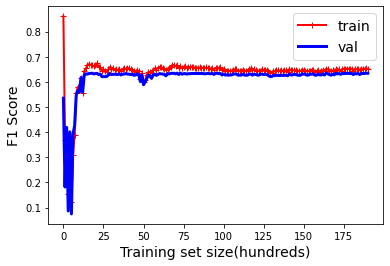

In [24]:
# check if SGD Classifier is overfitting 
plot_learning_curves(sgd_rnSearch.best_estimator_,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

SGD is not overfitting, but out-of-sample accuracy dropped from the previous two models.

<h2>SVM with Gaussian RBF kernel</h2>

In [25]:
from sklearn.svm import SVC

svc_rbf = SVC(kernel='rbf',random_state=42)
svc_rbf.fit(X_train_scale,y_train)
svc_rbf_pred = svc_rbf.predict(X_valid_scale)
accuracy_score(y_valid,svc_rbf_pred)

0.8175

In [26]:
#search for good hyperparameter
from scipy.stats import reciprocal

param_distribus = {"gamma": reciprocal(0.001, 0.1), "C": uniform(0.001, 3)}

svc_rbf = SVC(kernel='rbf',random_state=42)

svc_rbf_rnSearch = RandomizedSearchCV(svc_rbf, param_distributions= param_distribus,
                                  n_iter=25,cv=5,scoring='f1',random_state=42,
                                  verbose=2,n_jobs=-1)

svc_rbf_rnSearch.fit(X_train_scale,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=25, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda96f7c970>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda99162fa0>},
                   random_state=42, scoring='f1', verbose=2)

In [27]:
svc_rbf_rnSearch.best_params_

{'C': 2.897896099223678, 'gamma': 0.04138040112561014}

In [28]:
svc_rbf_rnSearch.best_score_

0.4605452319247642

In [30]:
y1 = svc_rbf_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.82

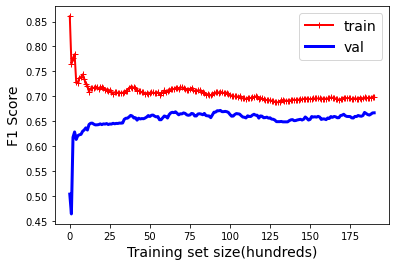

In [31]:
# check if SVC Gaussian RBF kernel is overfitting 
plot_learning_curves(svc_rbf_rnSearch.best_estimator_,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

SVM with RBF has by far the best performance, but the graph signifies a significant overfitting.

<h2>Random Forest</h2>

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, bootstrap= True,oob_score=True,
                                random_state=42, n_jobs=-1)
forest.fit(X_train_scale,y_train)
forest.oob_score_

0.8168229166666666

In [33]:
#search for good hyperparameter 
param_distribus = {'n_estimators':randint(50,200),'max_depth':randint(1,4),'max_features':randint(5,90)}

forest = RandomForestClassifier(bootstrap=True,random_state=42)

forest_rnSearch = RandomizedSearchCV(forest, param_distributions= param_distribus,
                                     n_iter=25,cv=3,scoring='f1',random_state=42,
                                     verbose=2)

forest_rnSearch.fit(X_train_scale,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END .....max_depth=3, max_features=56, n_estimators=142; total time=   2.4s
[CV] END .....max_depth=3, max_features=56, n_estimators=142; total time=   2.4s
[CV] END .....max_depth=3, max_features=56, n_estimators=142; total time=   2.3s
[CV] END ......max_depth=3, max_features=76, n_estimators=70; total time=   1.5s
[CV] END ......max_depth=3, max_features=76, n_estimators=70; total time=   1.5s
[CV] END ......max_depth=3, max_features=76, n_estimators=70; total time=   1.5s
[CV] END .....max_depth=3, max_features=87, n_estimators=124; total time=   3.0s
[CV] END .....max_depth=3, max_features=87, n_estimators=124; total time=   3.1s
[CV] END .....max_depth=3, max_features=87, n_estimators=124; total time=   3.0s
[CV] END .....max_depth=3, max_features=28, n_estimators=180; total time=   1.7s
[CV] END .....max_depth=3, max_features=28, n_estimators=180; total time=   1.7s
[CV] END .....max_depth=3, max_features=28, n_es

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=25,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda87016910>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda870036a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda87003130>},
                   random_state=42, scoring='f1', verbose=2)

In [34]:
forest_rnSearch.best_params_

{'max_depth': 3, 'max_features': 39, 'n_estimators': 130}

In [35]:
forest_rnSearch.best_score_

0.43036838822524426

In [36]:
y1 = forest_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.815625

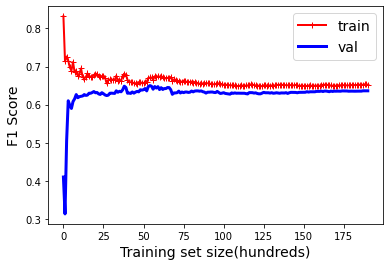

In [37]:
# check if Random Forest is overfitting 
plot_learning_curves(forest_rnSearch.best_estimator_,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

With a similar performance, Random Forest is slight overfitting.

<h2>ROC curve and ROC AUC: Logistic, SGD, RF, SVM RBF</h2>

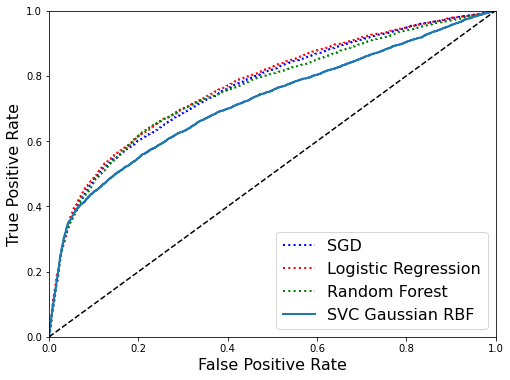

In [38]:
#compare Logistic Regression, SGD Classifier, Random Forest and SVC Gaussian RBF kernel
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
import matplotlib.pyplot as plt
import matplotlib as mpl

#plot function 
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

forest = forest_rnSearch.best_estimator_
forest.set_params(oob_score = True, warm_start = False).fit(X_train_scale,y_train)
y_scores_forest = forest.oob_decision_function_[:,1]
fpr_forest , tpr_forest ,thresholds_forest = roc_curve(y_train,y_scores_forest)

y_scores_SGDclf = cross_val_predict(sgd_rnSearch.best_estimator_,X_train_scale,y_train,
                                    cv=5,method="decision_function")
y_scores_SVCrbf = cross_val_predict(svc_rbf_rnSearch.best_estimator_,X_train_scale,y_train,
                                    cv=5,method="decision_function")
y_scores_logic = cross_val_predict(logistic_rnSearch.best_estimator_,X_train_scale,y_train,
                                   cv=5,method='predict_proba')

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train,y_scores_SGDclf)
fpr_rbf, tpr_rbf, thresholds_rbf = roc_curve(y_train,y_scores_SVCrbf)
fpr_logic, tpr_logic, thresholds_logic = roc_curve(y_train,y_scores_logic[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plt.plot(fpr_logic,tpr_logic,'r:',linewidth=2,label='Logistic Regression')
plt.plot(fpr_forest,tpr_forest,'g:',linewidth=2,label='Random Forest')
plot_roc_curve(fpr_rbf,tpr_rbf,'SVC Gaussian RBF')
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [39]:
auc_SGDclf = roc_auc_score(y_train,y_scores_SGDclf)
auc_SVCrbf = roc_auc_score(y_train,y_scores_SVCrbf)
auc_logistic = roc_auc_score(y_train,y_scores_logic[:,1])
auc_forest = roc_auc_score(y_train,y_scores_forest)
print('Area under curve:\n SGD Classifier:%f\n SVC Guassian RBF:%f\n Logistic Regression:%f\n Random Forest:%f'%(
auc_SGDclf,auc_SVCrbf,auc_logistic,auc_forest))

Area under curve:
 SGD Classifier:0.764501
 SVC Guassian RBF:0.720016
 Logistic Regression:0.771757
 Random Forest:0.759963


<h2>Hard/Soft Voting Classifier</h2>

In [40]:
#hard voting classifier
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(estimators=[('logistic',logistic_rnSearch.best_estimator_),
                                               ('SGD',sgd_rnSearch.best_estimator_),
                                               ('SVC_RBF',svc_rbf_rnSearch.best_estimator_),
                                               ('Forest',forest_rnSearch.best_estimator_)],voting='hard')
voting_clf_hard.fit(X_train_scale,y_train)
voting_clf_hard_valid_pred = voting_clf_hard.predict(X_valid_scale)
accuracy_score(y_valid,voting_clf_hard_valid_pred)

0.8160416666666667

In [41]:
f1_score(y_valid,voting_clf_hard_valid_pred)

0.40458530006743093

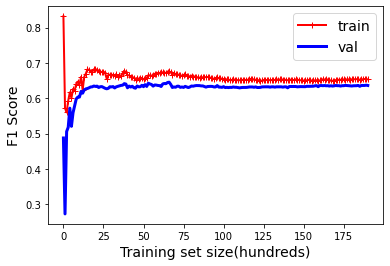

In [42]:
# check if hard voting classifier is overfitting 
plot_learning_curves(voting_clf_hard,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

In [43]:
#soft voting classifier
voting_clf_soft = VotingClassifier(estimators=[('logistic',logistic_rnSearch.best_estimator_),
                                               ('SVC_RBF',svc_rbf_rnSearch.best_estimator_.set_params(probability=True)),
                                               ('Forest',forest_rnSearch.best_estimator_)], voting='soft')
voting_clf_soft.fit(X_train_scale,y_train)
voting_clf_soft_valid_pred = voting_clf_soft.predict(X_valid_scale)
accuracy_score(y_valid,voting_clf_soft_valid_pred)

0.8177083333333334

In [44]:
f1_score(y_valid,voting_clf_soft_valid_pred)

0.43511943189154295

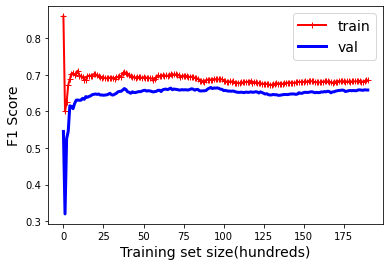

In [45]:
# check if soft voting classifier is overfitting 
plot_learning_curves(voting_clf_soft,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()


Again, slight overfitting is observed in both voting classifers.

<h2>Adaboost</h2>

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50,
                         algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada.fit(X_train_scale, y_train)
ada_pred = ada.predict(X_valid_scale)
accuracy_score(y_valid,ada_pred)

0.8120833333333334

In [47]:
#search for good hyperparameter
param_distribus = {'n_estimators':randint(50,200),'learning_rate':uniform(0,1)}

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME.R",random_state=42)

ada_rnSearch = RandomizedSearchCV(ada, param_distributions = param_distribus,
                                  n_iter=25, cv=5, scoring='f1', random_state=42, 
                                  verbose=2)
ada_rnSearch.fit(X_train_scale,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .learning_rate=0.3745401188473625, n_estimators=142; total time=   3.1s
[CV] END .learning_rate=0.3745401188473625, n_estimators=142; total time=   3.0s
[CV] END .learning_rate=0.3745401188473625, n_estimators=142; total time=   3.0s
[CV] END .learning_rate=0.3745401188473625, n_estimators=142; total time=   3.0s
[CV] END .learning_rate=0.3745401188473625, n_estimators=142; total time=   3.0s
[CV] END .learning_rate=0.1834347898661638, n_estimators=121; total time=   2.6s
[CV] END .learning_rate=0.1834347898661638, n_estimators=121; total time=   2.6s
[CV] END .learning_rate=0.1834347898661638, n_estimators=121; total time=   2.6s
[CV] END .learning_rate=0.1834347898661638, n_estimators=121; total time=   2.6s
[CV] END .learning_rate=0.1834347898661638, n_estimators=121; total time=   2.6s
[CV] END .learning_rate=0.5986584841970366, n_estimators=152; total time=   3.2s
[CV] END .learning_rate=0.5986584841970366, n_e

[CV] END learning_rate=0.015966252220214194, n_estimators=179; total time=   3.8s
[CV] END learning_rate=0.015966252220214194, n_estimators=179; total time=   3.7s
[CV] END learning_rate=0.015966252220214194, n_estimators=179; total time=   3.8s
[CV] END learning_rate=0.015966252220214194, n_estimators=179; total time=   3.8s
[CV] END .learning_rate=0.6842330265121569, n_estimators=160; total time=   3.4s
[CV] END .learning_rate=0.6842330265121569, n_estimators=160; total time=   3.4s
[CV] END .learning_rate=0.6842330265121569, n_estimators=160; total time=   3.3s
[CV] END .learning_rate=0.6842330265121569, n_estimators=160; total time=   3.4s
[CV] END .learning_rate=0.6842330265121569, n_estimators=160; total time=   3.3s
[CV] END ..learning_rate=0.6832635188254582, n_estimators=57; total time=   1.2s
[CV] END ..learning_rate=0.6832635188254582, n_estimators=57; total time=   1.2s
[CV] END ..learning_rate=0.6832635188254582, n_estimators=57; total time=   1.2s
[CV] END ..learning_rate

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=42),
                   n_iter=25,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda99cf2a00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda9915d3a0>},
                   random_state=42, scoring='f1', verbose=2)

In [48]:
ada_rnSearch.best_params_

{'learning_rate': 0.9422017556848528, 'n_estimators': 63}

In [49]:
ada_rnSearch.best_score_

0.45806806725468147

In [50]:
y1 = ada_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.8185416666666666

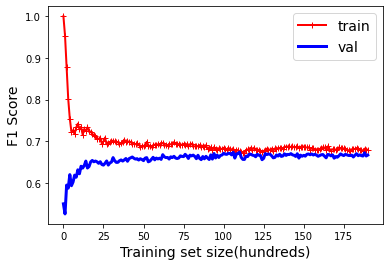

In [51]:
# check if Adaboost is overfitting 
plot_learning_curves(ada_rnSearch.best_estimator_,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

Adaboost is not overfitting as much and has a good performance.

<h2>Gradient Boosting</h2>

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

gradientBoost = GradientBoostingClassifier(max_depth=9,learning_rate=0.01,n_estimators=100,random_state=42)
gradientBoost.fit(X_train_scale,y_train)
gradientBoost_valid_pred = gradientBoost.predict(X_valid_scale)
accuracy_score(y_valid,gradientBoost_valid_pred)

0.813125

In [53]:
# search for good hyperparameter
param_distribus = {'max_depth':randint(1,4),'n_estimators':randint(5,20),'learning_rate':uniform(0,0.15)}

gradientBoost = GradientBoostingClassifier(random_state=42)

gradientBoost_rnSearch = RandomizedSearchCV(gradientBoost, param_distributions = param_distribus,
                                            n_iter=25, cv=5, scoring='f1', random_state=42, 
                                            verbose=2)

gradientBoost_rnSearch.fit(X_train_scale,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END learning_rate=0.05618101782710437, max_depth=1, n_estimators=19; total time=   0.3s
[CV] END learning_rate=0.05618101782710437, max_depth=1, n_estimators=19; total time=   0.3s
[CV] END learning_rate=0.05618101782710437, max_depth=1, n_estimators=19; total time=   0.3s
[CV] END learning_rate=0.05618101782710437, max_depth=1, n_estimators=19; total time=   0.3s
[CV] END learning_rate=0.05618101782710437, max_depth=1, n_estimators=19; total time=   0.3s
[CV] END learning_rate=0.10979909127171077, max_depth=1, n_estimators=9; total time=   0.2s
[CV] END learning_rate=0.10979909127171077, max_depth=1, n_estimators=9; total time=   0.2s
[CV] END learning_rate=0.10979909127171077, max_depth=1, n_estimators=9; total time=   0.2s
[CV] END learning_rate=0.10979909127171077, max_depth=1, n_estimators=9; total time=   0.2s
[CV] END learning_rate=0.10979909127171077, max_depth=1, n_estimators=9; total time=   0.2s
[CV] END lear

[CV] END learning_rate=0.03463407384332235, max_depth=3, n_estimators=16; total time=   0.7s
[CV] END learning_rate=0.03463407384332235, max_depth=3, n_estimators=16; total time=   0.7s
[CV] END learning_rate=0.018305735226716822, max_depth=1, n_estimators=12; total time=   0.2s
[CV] END learning_rate=0.018305735226716822, max_depth=1, n_estimators=12; total time=   0.2s
[CV] END learning_rate=0.018305735226716822, max_depth=1, n_estimators=12; total time=   0.2s
[CV] END learning_rate=0.018305735226716822, max_depth=1, n_estimators=12; total time=   0.2s
[CV] END learning_rate=0.018305735226716822, max_depth=1, n_estimators=12; total time=   0.2s
[CV] END learning_rate=0.005158278167282759, max_depth=2, n_estimators=5; total time=   0.2s
[CV] END learning_rate=0.005158278167282759, max_depth=2, n_estimators=5; total time=   0.2s
[CV] END learning_rate=0.005158278167282759, max_depth=2, n_estimators=5; total time=   0.2s
[CV] END learning_rate=0.005158278167282759, max_depth=2, n_estim

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=25,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda87003ee0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda99d0ec70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda87016e50>},
                   random_state=42, scoring='f1', verbose=2)

In [54]:
gradientBoost_rnSearch.best_params_

{'learning_rate': 0.14606332782621886, 'max_depth': 3, 'n_estimators': 18}

In [55]:
gradientBoost_rnSearch.best_score_

0.45052734748926804

In [56]:
y1 = gradientBoost_rnSearch.best_estimator_.predict(X_valid_scale)
accuracy_score(y_valid,y1)

0.8164583333333333

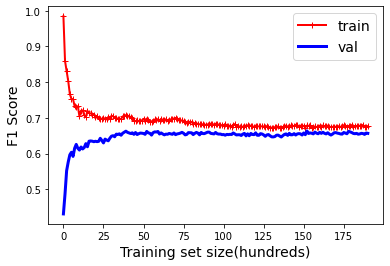

In [57]:
# check if Gradient Boosting is overfitting 
plot_learning_curves(gradientBoost_rnSearch.best_estimator_,X_train_scale,y_train,X_valid_scale,y_valid)
plt.show()

Gradient Boosting has similar performance to Adaboost, and similar degree of overfitting.

<h2>Artificial Neuron Network</h2>

In [4]:
import tensorflow as tf
from tensorflow import keras

def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()
    
def exponential_decay(lr0, s):
    return lambda epoch: lr0 * 0.1**(epoch / s)


In [5]:
reset_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(91))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu",kernel_initializer="he_normal"))
    model.add(keras.layers.Dense(1, activation = "sigmoid"))
    
    model.compile(loss="binary_crossentropy", optimizer="nadam", metrics = ["AUC","accuracy"])
    return model

model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [5, 15, 25, 35, 45],
    "n_neurons": np.arange(1, 200)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist()
}

rnd_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=10, cv=3, verbose=2)


lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01, s=20))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001)

rnd_search_cv.fit(X_train_scale, y_train, epochs=30,
                  validation_data=(X_valid_scale, y_valid),
                  callbacks=[lr_scheduler,early_stopping_cb])
        


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/30
400/400 [==============================] - 7s 5ms/step - loss: 168.9898 - auc: 0.4838 - accuracy: 0.7695 - val_loss: 0.5287 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.5298 - auc: 0.4944 - accuracy: 0.7784 - val_loss: 0.5286 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 0.5206 - auc: 0.5006 - accuracy: 0.7855 - val_loss: 0.5286 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.5282 - auc: 0.4861 - accuracy: 0.7797 - val_loss: 0.5315 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 5/30
400/400 [==============================] - 1s 3ms/step - loss: 0.5254 - auc: 0.4833 - accuracy: 0.7823 - val_loss: 0.5288 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 6/30
400/400 [==============================] - 1s 3ms/step -

Epoch 11/30
400/400 [==============================] - 0s 1ms/step - loss: 0.4161 - auc: 0.7875 - accuracy: 0.8318 - val_loss: 0.4403 - val_auc: 0.7626 - val_accuracy: 0.8152
Epoch 12/30
400/400 [==============================] - 0s 1ms/step - loss: 0.4181 - auc: 0.7851 - accuracy: 0.8280 - val_loss: 0.4418 - val_auc: 0.7606 - val_accuracy: 0.8158
Epoch 13/30
400/400 [==============================] - 0s 1ms/step - loss: 0.4294 - auc: 0.7738 - accuracy: 0.8246 - val_loss: 0.4430 - val_auc: 0.7611 - val_accuracy: 0.8175
Epoch 14/30
200/200 [==============================] - 0s 553us/step - loss: 0.4407 - auc: 0.7762 - accuracy: 0.8156
[CV] END learning_rate=0.001546374596250726, n_hidden=5, n_neurons=2; total time=   7.0s
Epoch 1/30
400/400 [==============================] - 1s 1ms/step - loss: 0.5675 - auc: 0.6290 - accuracy: 0.7846 - val_loss: 0.4459 - val_auc: 0.7507 - val_accuracy: 0.8192
Epoch 2/30
400/400 [==============================] - 0s 972us/step - loss: 0.4375 - auc: 0.764

400/400 [==============================] - 5s 5ms/step - loss: 0.9961 - auc: 0.4948 - accuracy: 0.7611 - val_loss: 0.6772 - val_auc: 0.6075 - val_accuracy: 0.7750
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 12.5680 - auc: 0.5056 - accuracy: 0.7394 - val_loss: 0.6761 - val_auc: 0.4436 - val_accuracy: 0.7227
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 0.7274 - auc: 0.4999 - accuracy: 0.7736 - val_loss: 0.5287 - val_auc: 0.5005 - val_accuracy: 0.7788
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5345 - auc: 0.4954 - accuracy: 0.7741 - val_loss: 0.5285 - val_auc: 0.5005 - val_accuracy: 0.7788
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5276 - auc: 0.4792 - accuracy: 0.7798 - val_loss: 0.5285 - val_auc: 0.5039 - val_accuracy: 0.7788
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5977 - auc: 0.5001 - accuracy: 0.7790 - val_loss: 0.5281 - val_a

Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5254 - auc: 0.4945 - accuracy: 0.7814 - val_loss: 0.5286 - val_auc: 0.5130 - val_accuracy: 0.7788
Epoch 6/30
400/400 [==============================] - 1s 4ms/step - loss: 0.5169 - auc: 0.5293 - accuracy: 0.7859 - val_loss: 0.4999 - val_auc: 0.6139 - val_accuracy: 0.7871
Epoch 7/30
400/400 [==============================] - 2s 5ms/step - loss: 0.4772 - auc: 0.6325 - accuracy: 0.8049 - val_loss: 0.4884 - val_auc: 0.6683 - val_accuracy: 0.7908
Epoch 8/30
400/400 [==============================] - 2s 5ms/step - loss: 0.5564 - auc: 0.5693 - accuracy: 0.7799 - val_loss: 0.5309 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 9/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5350 - auc: 0.4841 - accuracy: 0.7745 - val_loss: 0.5289 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 10/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5358 - auc: 0.4953 - accuracy: 0.7734 - val_loss: 0.5

Epoch 10/30
400/400 [==============================] - 1s 4ms/step - loss: 0.5360 - auc: 0.4936 - accuracy: 0.7734 - val_loss: 0.5285 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 11/30
200/200 [==============================] - 0s 1ms/step - loss: 0.5320 - auc: 0.5000 - accuracy: 0.7761
[CV] END learning_rate=0.018803107621165455, n_hidden=25, n_neurons=121; total time=  19.6s
Epoch 1/30
400/400 [==============================] - 4s 4ms/step - loss: 0.9982 - auc: 0.4887 - accuracy: 0.7649 - val_loss: 0.5313 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.5336 - auc: 0.4937 - accuracy: 0.7756 - val_loss: 980.0402 - val_auc: 0.5000 - val_accuracy: 0.2212
Epoch 3/30
400/400 [==============================] - 1s 4ms/step - loss: 339.8171 - auc: 0.5153 - accuracy: 0.7163 - val_loss: 0.5147 - val_auc: 0.6693 - val_accuracy: 0.7788
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.6176 - auc: 0.57

200/200 [==============================] - 0s 550us/step - loss: 0.4325 - auc: 0.7804 - accuracy: 0.8223
[CV] END learning_rate=0.0011137872537121593, n_hidden=5, n_neurons=47; total time=  10.9s
Epoch 1/30
400/400 [==============================] - 7s 8ms/step - loss: 86.0492 - auc: 0.4890 - accuracy: 0.7668 - val_loss: 0.5289 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 2/30
400/400 [==============================] - 3s 7ms/step - loss: 0.5309 - auc: 0.4861 - accuracy: 0.7784 - val_loss: 0.5286 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 3/30
400/400 [==============================] - 3s 7ms/step - loss: 0.5206 - auc: 0.4984 - accuracy: 0.7855 - val_loss: 0.5286 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 4/30
400/400 [==============================] - 3s 7ms/step - loss: 0.5283 - auc: 0.4861 - accuracy: 0.7797 - val_loss: 0.5322 - val_auc: 0.5000 - val_accuracy: 0.7788
Epoch 5/30
400/400 [==============================] - 3s 7ms/step - loss: 0.5255 - auc: 0.4837 - accuracy: 

600/600 [==============================] - 1s 990us/step - loss: 0.4200 - auc: 0.7902 - accuracy: 0.8262 - val_loss: 0.4343 - val_auc: 0.7706 - val_accuracy: 0.8192
Epoch 18/30
600/600 [==============================] - 1s 981us/step - loss: 0.4181 - auc: 0.7897 - accuracy: 0.8259 - val_loss: 0.4384 - val_auc: 0.7697 - val_accuracy: 0.8181


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff8ad0cceb0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.0...
                                                          0.00502142573

In [6]:
rnd_search_cv.best_params_

{'n_neurons': 47, 'n_hidden': 5, 'learning_rate': 0.0011137872537121593}

In [7]:
model = rnd_search_cv.best_estimator_.model
run = model.fit(X_train_scale, y_train, epochs=200,
                validation_data=(X_valid_scale, y_valid),
                callbacks=[early_stopping_cb, lr_scheduler])

Epoch 1/200
600/600 [==============================] - 1s 1ms/step - loss: 0.4391 - auc: 0.7681 - accuracy: 0.8197 - val_loss: 0.4438 - val_auc: 0.7686 - val_accuracy: 0.8179
Epoch 2/200
600/600 [==============================] - 1s 989us/step - loss: 0.4320 - auc: 0.7740 - accuracy: 0.8230 - val_loss: 0.4387 - val_auc: 0.7712 - val_accuracy: 0.8181
Epoch 3/200
600/600 [==============================] - 1s 1ms/step - loss: 0.4321 - auc: 0.7760 - accuracy: 0.8220 - val_loss: 0.4409 - val_auc: 0.7661 - val_accuracy: 0.8171
Epoch 4/200
600/600 [==============================] - 1s 992us/step - loss: 0.4344 - auc: 0.7720 - accuracy: 0.8229 - val_loss: 0.4396 - val_auc: 0.7647 - val_accuracy: 0.8190
Epoch 5/200
600/600 [==============================] - 1s 995us/step - loss: 0.4374 - auc: 0.7765 - accuracy: 0.8052 - val_loss: 0.4583 - val_auc: 0.7675 - val_accuracy: 0.7785
Epoch 6/200
600/600 [==============================] - 1s 1ms/step - loss: 0.4375 - auc: 0.7747 - accuracy: 0.8166 - va

In [8]:
max(run.history["val_auc"])

0.7740323543548584

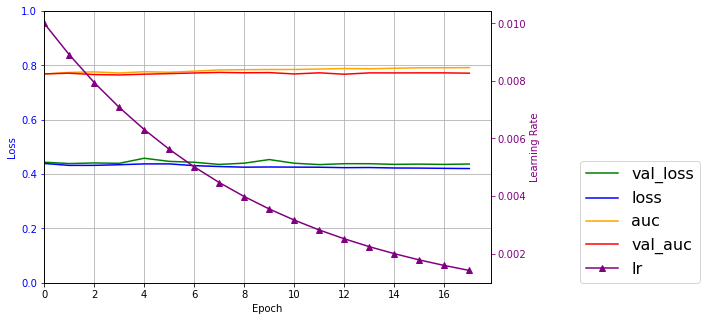

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
ln1=plt.plot(run.epoch, run.history["val_loss"], "g-", label='val_loss')
ln2=plt.plot(run.epoch, run.history["loss"], "b-", label='loss')
ln3=plt.plot(run.epoch, run.history["auc"], "-", color='orange', label='auc')
ln4=plt.plot(run.epoch, run.history["val_auc"], "r-", label='val_auc')
plt.xlabel("Epoch")
plt.ylabel("Loss", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, None)
plt.gca().set_ylim(0, 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ln5 = ax2.plot(run.epoch, run.history["lr"], "^-", color='purple', label='lr')
ax2.set_ylabel("Learning Rate", color='purple')
ax2.tick_params('y', colors='purple')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=(1.2,0), fontsize=16)
plt.show()

ANN gives the best out-of sample auc.

<h2>Performance on Test set</h2>

<h3>SGD</h3>

In [64]:
# check on test set
X_test_scale = final_pipeline.transform(X_test)

#SGD Classifier
sgd_test_pred = sgd_rnSearch.best_estimator_.predict(X_test_scale)
accuracy_score(y_test,sgd_test_pred)

0.8165

<h3>Random Forest</h3>

In [65]:
#Random Forest 
forest_test_pred = forest_rnSearch.best_estimator_.predict(X_test_scale)
accuracy_score(y_test,forest_test_pred)

0.8155

<h3>Adaboost</h3>

In [66]:
# Adaboost
ada_test_pred = ada_rnSearch.best_estimator_.predict(X_test_scale)
accuracy_score(y_test,ada_test_pred)

0.8151666666666667

<h3>Gradient Boosting</h3>

In [67]:
# gradient boosting
gradientBoosting_test_pred = gradientBoost_rnSearch.best_estimator_.predict(X_test_scale)
accuracy_score(y_test,gradientBoosting_test_pred)

0.8168333333333333

<h3>ANN</h3>

In [12]:
#ANN
from sklearn.metrics import accuracy_score
ANN_test_pred_score = run.model.predict(X_test_scale)
ANN_test_pred = ANN_test_pred_score>0.5
accuracy_score(y_test,ANN_test_pred)

0.817

ANN gives the best test-set accuracy, although they are all very close.

<h2>Conclusion & Reflection</h2>

<h3>Conclusion</h3>

1. In terms of accuracy, currently there is no algorithm that can significantly outperform the default assumption (No one defaults).


2. Though the predicting accuracy of our models are not so high, it does not mean these models have no predicting power on credit cards defaults at all because it is a bias datasets and we should not judge our models on accuracy. Actually, according to 'Area Under Curve' metric of these models, SVC with Gaussian kernel achieves 0.720, Random Forest's AUC is 0.759963, SGD Classifier's is a little higher and achieves 0.7645, Logistic Regression's AUC is 0.7718, and ANN has the best AUC score, which is 0.7740. We can see that all of them are significantly higher than 0.5, so these models do have predicting power on credit cards defaults.


3. Major algorithms reach simlar performance, ANN with specified structure ourperforms the rest by a small margin.

<h3>Reflection</h3>

1. The observed period is too short (only 6 months). 6 months of information may not be sufficient.


2. Maybe the selected features are not representative (innate flaws of the data set).


3. To achieve more accurate prediction on credit card defaults, perhaps we need to add more informative explaining variables into the model.

<h2>Reference</h2>

1. http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients


2. Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.


3. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

<h2>Contribution of Group Members</h2>

<h3>Haotian Zhang:</h3>

**Model develope and analysis:** 

1. Linear SVM Classifier

2. SGD Classifier  

3. Adaboost  

4. Gradient Boosting  

5. Artificial Neuron Network

**Other:** 

1. Data context and variables descriptions 

2. Draw conclusions 

3. Format adjustment


<h3>Zepei Zhu:</h3> 

**Model develope and analysis:**

1. Logistic regression 

2. SVM with Gaussian kernel

3. Random Forest

4. Hard voting Classifier

5. Soft voting Classifier

**Other:**

1. Data preprocessing

2. Evaluate metrics selection

3. Evaluate models on test set